# Titanic Survival Classificaion:


##### in notebook section links

[imports](#imports)
[PCA](#pca_cell)
[Visualizations](#visualizations)
[Classification Models](#classification_models)

### Required Imports :
<a id='imports'></a>

In [1]:
#required libraries:
import pandas as pd;    
import numpy as np;

### Utility Functions:

In [2]:
#importing training and test data into pandas dataframe
def import_data(path):
    return pd.read_csv(path)



In [3]:
#utility functions
def print_info(df):
    return df.info()

def print_description(df):
    return df.describe()

def print_head(df, count=5):
    return df.head(count)

# function returns a dictionary of percentage of null values in a dataframe
def get_null_percent(df):
    null_percent_dict = {}
    
    for col in df.columns:
        null_percent_dict[col] = df[df[col].isnull() == True].loc[:,'Survived'].count()/ df.shape[0] *100
    
    return null_percent_dict

In [4]:
# get list of attributes with atleast 1 cell having a null value
def get_attributes_with_nulls(df):
    df_nulls = pd.Series(df.isna().any())
    return df_nulls[df_nulls == True].index.tolist()

def get_attributes_with_nulls_inorder(df):
    return    (df.isnull()
                 .sum(axis = 0)
                 .loc[df.isnull().sum() > 0]
                 .sort_values( ascending = True))


In [5]:
# print out results of 3 different stages of logistic regression
def print_logistic_regression_results(df):
    print(" simple logistic regg = {} \n min-max scaled logistic regg = {} \n grid -searched logistic regg = {}".
    format(logistic_regression_model(df), scaled_logistic_regression(df), gridSearch_logistic_regression_model(df)))

### Preprocess both training and testing dataframe :

In [6]:
def numeric_mapper(df, column_name):
    mapper = {}
    data_list = df[column_name].unique()
    data_list = ['missing' if pd.isnull(x) else x for x in data_list]
    data_list.sort()
    for i in range(0, len(data_list)):
        if data_list[i] == 'missing':
            mapper[np.nan] = 404
        else:    
            mapper[data_list[i]] = i
    return mapper
    
def data_preprocessor(df):
 
    df = (df.rename({'SibSp' : '# of Siblings', 
                                             'Parch': '# of Parents', 
                                             'Sex' : 'Gender',
                                             'Pclass' : 'Class'},
                                            axis = 1)
                                    .drop(['Name', 'Ticket', 'PassengerId'], axis = 1)
                                    .astype({'Gender' : pd.api.types.CategoricalDtype(df['Sex'].unique(), ordered=False), 
                                             'Class' : pd.api.types.CategoricalDtype(df['Pclass'].unique(), ordered=True)})
#                                     .replace({'Embarked' : {np.NaN : 'un-known'}})
                                    .replace({'Gender' : numeric_mapper(df, 'Sex'),
                                              'Embarked' : numeric_mapper(df, 'Embarked'),
                                              'Cabin' : numeric_mapper(df, 'Cabin'),
                                              'Age' : {np.nan : 404}})
                                    
    #                                 .loc[:]
                      )
    return df

### Dealing With Null Values In Attributes :

#### CASE 1 : Removing attributes with null values:

In [7]:
# In training only 2 attributes contains a major chunk of null data : Age and Cabin
def drop_null_attributes(df):
    df = (df.dropna(axis='columns')
         )
    return df

#### CASE 2: Remove rows with null values:

In [8]:
def drop_null_rows(df):
    df = (df.dropna(axis='rows')
         )
    return df

#### CASE 3: Replacing null attribute values with mean, median or mode

In [9]:
# replace nulls with averages 
def replace_null_with_mean(col):
    if col.dtype.name == "category":
        col = col.replace(np.nan,col.mode())
    else:
        col = col.replace(np.nan, col.mean())
    return col

def replace_nulls_phase_1(df):
    df = (df.apply(replace_null_with_mean, axis = 0)
         )
    return df

#### CASE 4: Group attributes with similar values and replace null values with mean or mode values of that specific group

In [10]:
# Function to return attributes with greatest correlation with the provided attribute
def top_correlations(df,attribute, count = 2):
    correlations_df  = df.corr()
    correlation_attribute = correlations_df[attribute]
    correlation_attribute = correlation_attribute.to_frame()
    correlation_attribute[attribute+'_mod'] = [ x if x > 0 else -1*x for x in correlations_df[attribute]]
    return (correlation_attribute.sort_values(attribute+'_mod', ascending = False)[1: (count+1)].loc[:, attribute])
    

In [11]:
# form a dictionary structure of column with nulls as keys and attributes they are most correlated to as a list of values
def get_top_corr_dict(attribute_with_nulls):
    top_corr_dict = {}
    for attribute in attribute_with_nulls:
        top_corr_dict[attribute] = top_correlations(titanic_train_4, attribute)
    return top_corr_dict

In [12]:
# dataframe of values based on averages columns with null values based on groupby result of previous step
def get_vals_based_on_corr_groups(top_corr_dict, attr_type):
    values_based_corr_dict = {}
    for attr in top_corr_dict.keys():
        if attr_type[attr] == 'category':
            df = titanic_train_4.groupby(top_corr_dict[attr].index.tolist(), as_index= False)[attr].agg(lambda x : x.value_counts().index[0] if len(x.value_counts()) is not 0 else titanic_train_4[attr].value_counts().index[1])
        else:
            df = titanic_train_4.groupby(top_corr_dict[attr].index.tolist(),  as_index= False)[attr].agg(lambda x : x.mean() if pd.isnull(x.mean()) is not True else titanic_train_4[attr].value_counts().index[0])
        values_based_corr_dict[attr] = df 
    return values_based_corr_dict

#### CASE 5 A: replace null values by creating a simple prediction model from remaining non null attributes in  (PARALLEL)

In [13]:
# [x for x in titanic_train_5.columns if x not in [y for y in attribute_with_nulls if y != 'Age']] - list comprehension to remove non important nulls

# split groups into train and predict dataframe sets based on condition if attribute.val = np.nan
def attr_train_predict_split(df, attribute_with_nulls, attr):
    df= df.loc[:, [x for x in df.columns if x not in [y for y in attribute_with_nulls if y != attr]]]
    train_set = df[np.isnan(df[attr]) == False]
    predict_set = df[np.isnan(df[attr])]
    return (train_set, predict_set)

In [14]:
# predict substitutes for null values by training a simple KNN model on the data split of non null attribute values
def predict_nulls(train_set, predict_set, attr, attr_type):
    from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
    X_train = train_set.loc[:, train_set.columns != attr]
    y_train = train_set[attr]

    X_predict = predict_set.loc[:, predict_set.columns != attr]
    y_predict = predict_set[attr]
    
    if(attr_type == 'category'):
        return KNeighborsClassifier().fit(X_train, y_train).predict(X_predict)
    else:
        return KNeighborsRegressor().fit(X_train, y_train).predict(X_predict)

#### CASE 5 B: replace null values by creating a simpe prediction model from remaining non null attributes in (SERIES)

In [15]:
# split groups into train and predict dataframe sets based on condition if attribute.val = np.nan
def attr_train_predict_split_inorder(df, attribute_with_nulls_inorder, attr):
    df= df.loc[:, [x for x in df.columns if (df[x].isna().any() != True) | (x == attr) ]]
    train_set = df[np.isnan(df[attr]) == False]
    predict_set = df[np.isnan(df[attr])]
    return (train_set, predict_set)

In [16]:
# predict substitutes for null values by training a simple KNN model on the data split of non null attribute values
def predict_nulls_inorder(train_set, predict_set, attr, attr_type):
    from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
    X_train = train_set.loc[:, train_set.columns != attr]
    y_train = train_set[attr]

    X_predict = predict_set.loc[:, predict_set.columns != attr]
    y_predict = predict_set[attr]
    
    if(attr_type == 'category'):
        return KNeighborsClassifier().fit(X_train, y_train).predict(X_predict)
    else:
        return KNeighborsRegressor().fit(X_train, y_train).predict(X_predict)

### Preprocessing :

#### MinMax Scaler :

In [17]:
def min_max_scale_data(train_set, test_set):
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler(feature_range= (-1,1))
    train_scaled = scaler.fit_transform(train_set)
    test_scaled = scaler.transform(test_set)
    return (train_scaled, test_scaled)

#### Standard Scaler: <font color='red'> in progress</font>

In [18]:
# scaled data to a mean = 0 , std = 1
def standard_scale_data(train_set, test_set):
    from sklearn.preprocessing import StandardScaler
    std_scaler = StandardScaler()
    std_scaler.fit(train_set)
    train_scaled = std_scaler.transform(train_set)
    test_scaled = std_scaler.transform(test_set)
    return (train_scaled, test_scaled)

#### PCA (Principal Component Analysis) : <font color='red'> work in progress</font>

In [19]:
def get_pca_dataset(train_set, test_set, features = 2):
    from sklearn.decomposition import PCA
    train_scaled, test_scaled = standard_scale_data(train_set, test_set)
    pca = PCA(n_components= features)
    pca.fit(train_scaled)
    pca_train = pca.transform(train_scaled)
    pca_test = pca.transform(test_scaled)
    return (pca_train, pca_test)
    

#### Train Test Splitter:

In [20]:
def train_test_split_data(df):
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(df.loc[:, df.columns!= 'Survived'], df['Survived'], test_size = 0.75, random_state = 0)
    return (X_train, X_test, y_train, y_test)

### Visualizations :
<a id="visualizations"></a>

#### Heatmap : correlation matrix visualization :

In [21]:
# plot a heatmap of correlation matrix of attribute variables
def plot_correlation_heatmap(correlation_data):
    %matplotlib inline
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(9, 6))
    import seaborn as sns
    return sns.heatmap(correlation_data, annot = True)

#### Plot Scatter : simple 2 dimentional scatter plot 

In [54]:
def plot_2d_scatter(x,y):
    %matplotlib notebook
    import matplotlib.pyplot as plt
    plt.scatter(y, x)

#### Decision boundary view in PCA:
<a id='pca_cell'></a>

In [22]:
''' 
data : 2 dimentional data points for visualization 
clf : classifier used model used for classification and prediction'''
def plot_decision_boundary_two_variable(data, clf):
    X_mat = data[:, 0]
    y_mat = data[:, 1]

    # Create color maps
    cmap_light = ListedColormap(['#FFFFAA', '#AAFFAA', '#AAAAFF','#EFEFEF'])
    cmap_bold  = ListedColormap(['#FFFF00', '#00FF00', '#0000FF','#000000'])

    # classification model to be tested
    from sklearn.model_selection import train_test_split
    from sklearn.linear_model import LogisticRegression

    X_train, X_test, y_train, y_test = train_test_split(df.loc[:, df.columns!= 'Survived'], df['Survived'], test_size = 0.75, random_state = 0)
    clf = LogisticRegression(solver = 'liblinear') #solver : liblinear good for small datasets
    clf.fit(data, ) # dead end here

    # Plot the decision boundary by assigning a color in the color map
    # to each mesh point.
    
    mesh_step_size = .01  # step size in the mesh
    plot_symbol_size = 50
    
    x_min, x_max = X_mat[:, 0].min() - 1, X_mat[:, 0].max() + 1
    y_min, y_max = X_mat[:, 1].min() - 1, X_mat[:, 1].max() + 1
    xx, yy = numpy.meshgrid(numpy.arange(x_min, x_max, mesh_step_size),
                         numpy.arange(y_min, y_max, mesh_step_size))
    Z = clf.predict(numpy.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot training points
    plt.scatter(X_mat[:, 0], X_mat[:, 1], s=plot_symbol_size, c=y, cmap=cmap_bold, edgecolor = 'black')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    title = "Neighbors = {}".format(n_neighbors)
    if (X_test is not None):
        train_score = clf.score(X_mat, y_mat)
        test_score  = clf.score(X_test, y_test)
        title = title + "\nTrain score = {:.2f}, Test score = {:.2f}".format(train_score, test_score)

    patch0 = mpatches.Patch(color='#FFFF00', label='class 0')
    patch1 = mpatches.Patch(color='#000000', label='class 1')
    plt.legend(handles=[patch0, patch1])

    plt.xlabel('Feature 0')
    plt.ylabel('Feature 1')
    plt.title(title)

    plt.show()

### Classification Models :
<a id="classification_models"></a>

#### Logistic Regression 

In [23]:
def logistic_regression_model(df):
    from sklearn.model_selection import train_test_split
    from sklearn.linear_model import LogisticRegression

    X_train, X_test, y_train, y_test = train_test_split(df.loc[:, df.columns!= 'Survived'], df['Survived'], test_size = 0.75, random_state = 0)
    clf = LogisticRegression(solver = 'liblinear') #solver : liblinear good for small datasets
    clf.fit(X_train, y_train)
    return clf.score(X_test, y_test)

#### Grid Searched : Logistic regression 

In [24]:
def  gridSearch_logistic_regression_model(df):
    from sklearn.model_selection import train_test_split
    from sklearn.linear_model import LogisticRegression
    from sklearn.model_selection import train_test_split
    from sklearn.model_selection import GridSearchCV
    
    logistic_reg = LogisticRegression(solver = 'liblinear')
    parameters = {'penalty' : ('l1', 'l2'),
                   'C' : [0.1, 10]
                 }
    clf = GridSearchCV(logistic_reg, parameters, cv = 5, iid= True)
    
    X_train, X_test, y_train, y_test = train_test_split(df.loc[:, df.columns!= 'Survived'], df['Survived'], test_size = 0.75, random_state = 0)
    X_train, X_test = min_max_scale_data(X_train, X_test)
    clf.fit(X_train, y_train)
    return clf.score(X_test, y_test)
    
    

#### Scaled: Logistic Regression

In [25]:
def scaled_logistic_regression(df):
    from sklearn.linear_model import LogisticRegression
    from sklearn.model_selection import train_test_split
    
    clf = LogisticRegression(solver = 'liblinear')
    X_train, X_test, y_train, y_test = train_test_split(df.loc[:, df.columns!= 'Survived'], df['Survived'], test_size = 0.75, random_state = 0)
    X_train, X_test = min_max_scale_data(X_train, X_test)
    clf.fit(X_train, y_train)
    return clf.score(X_test, y_test)   

### Test Cases :

In [26]:
titanic_train = import_data("./../../../Datasets/Titanic/train.csv");
titanic_test =  import_data("./../../../Datasets/Titanic/test.csv")

In [27]:
# preprocessing phase 1 for training and validation dataset
titanic_train = data_preprocessor(titanic_train)
print_head(titanic_train)

,Survived,Class,Gender,Age,# of Siblings,# of Parents,Fare,Cabin,Embarked
0,0,3,1,22.0,1,0,7.2500,404,2
1,1,1,0,38.0,1,0,71.2833,81,0
2,1,3,0,26.0,0,0,7.9250,404,2
3,1,1,0,35.0,1,0,53.1000,55,2
4,0,3,1,35.0,0,0,8.0500,404,2


In [28]:
titanic_test = data_preprocessor(titanic_test)
print_head(titanic_test)

,Class,Gender,Age,# of Siblings,# of Parents,Fare,Cabin,Embarked
0,3,1,34.5,0,0,7.8292,404,1
1,3,0,47.0,1,0,7.0000,404,2
2,2,1,62.0,0,0,9.6875,404,1
3,3,1,27.0,0,0,8.6625,404,2
4,3,0,22.0,1,1,12.2875,404,2


#### Test Case 1:

In [29]:
#removed columns with null values
titanic_train_1 = titanic_train.replace({404 : np.nan})
titanic_train_1 = drop_null_attributes(titanic_train_1)
logistic_regression_model(titanic_train_1)

0.7772795216741405

#### Test Case 2:

In [30]:
# removed rows with null values
titanic_train_2 = titanic_train.replace({404 : np.nan})
titanic_train_2 = drop_null_rows(titanic_train_2)
logistic_regression_model(titanic_train_2)

0.7391304347826086

#### Test Case 3:

In [31]:
# replaced null values with mean and mode
titanic_train_3 = titanic_train.replace({404 : np.nan})
titanic_train_3 = replace_nulls_phase_1(titanic_train_3)
logistic_regression_model(titanic_train_3)

0.7802690582959642

#### Test Case 4:

In [32]:
# replace nulls with correlation and groupby based values
titanic_train_4 = (titanic_train.replace({404 : np.nan})
                                .astype({'Class' : int})
                  )

attribute_with_nulls = get_attributes_with_nulls(titanic_train_4)
top_corr_dict = get_top_corr_dict(attribute_with_nulls)

# used to switch mechanism of finding null value replacements based on type of attribute
attr_type = {'Age' : 'discrete', 'Cabin' : 'category', 'Embarked': 'category'}
vals_based_on_corr_groups = get_vals_based_on_corr_groups(top_corr_dict, attr_type)

# function to replace null values in the dataframe using dictionary of null replacments gained using previous steps data
def update_null_vals(row, vals_based_on_corr_groups):
    for attr in vals_based_on_corr_groups.keys():
        if np.isnan(row[attr]):
            frame = vals_based_on_corr_groups[attr]
            row[attr] = frame[(frame[frame.columns[0]] == row[frame.columns[0]]) & (frame[frame.columns[1]] == row[frame.columns[1]]) ].loc[:, attr]
    
    return row

titanic_train_4 = titanic_train_4.apply(update_null_vals, axis = 1, args= (vals_based_on_corr_groups, ));

In [33]:
logistic_regression_model(titanic_train_4)

0.7698056801195815

#### Test Case 5 A:

In [34]:
titanic_train_5_A = (titanic_train.replace({404 : np.nan})
                                .astype({'Class' : int})
                  )

# get list of attributes which have at least 1 null value in the cells
attribute_with_nulls = get_attributes_with_nulls(titanic_train_5_A)

# used to switch between regression and classification model  of finding null value replacements based on type of attribute
attr_type = {'Age' : 'discrete', 'Cabin' : 'category', 'Embarked': 'category'}

# loop through and predict null attribute values by splitting data using function 1 and predicting values using function 2
for attr in attribute_with_nulls:
    #function 1
    train, predict = attr_train_predict_split(titanic_train_5_A, attribute_with_nulls, attr) 
    #function 2
    predicted_values = predict_nulls(train, predict, attr, attr_type[attr]) 
    # replace nulls with prediction reuslts
    titanic_train_5_A.loc[np.isnan(titanic_train_5_A[attr]), attr] =  predicted_values 
    
    

In [35]:
logistic_regression_model(titanic_train_5_A)

0.7937219730941704

#### TEST Case 5 B:

In [36]:
titanic_train_5_B= (titanic_train.replace({404 : np.nan})
                                .astype({'Class' : int})
                  )

# get list of attributes which have at least 1 null value in the cells in decending order with count
attribute_with_nulls_inorder = get_attributes_with_nulls_inorder(titanic_train_5_B)

# used to switch between regression and classification model  of finding null value replacements based on type of attribute
attr_type = {'Age' : 'discrete', 'Cabin' : 'category', 'Embarked': 'category'}

#predicting the attribute with least nulls and using them to predict future null attribute values iteratively
for attr in attribute_with_nulls_inorder.index.tolist():
    train, predict = attr_train_predict_split_inorder(titanic_train_5_B, attribute_with_nulls_inorder.index.tolist(), attr)
    predicted_values = predict_nulls(train, predict, attr, attr_type[attr]) 
    titanic_train_5_B.loc[np.isnan(titanic_train_5_B[attr]), attr] =  predicted_values 

In [37]:
logistic_regression_model(titanic_train_5_B)

0.7982062780269058

In [38]:
gridSearch_logistic_regression_model(titanic_train_5_B)

C:\Users\Saurabh\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int32, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


0.7982062780269058

In [39]:
scaled_logistic_regression(titanic_train_5_B)

C:\Users\Saurabh\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int32, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


0.7982062780269058

### feature analysis:

In [40]:
titanic_train = (titanic_train.replace({404 : np.nan})
                                .astype({'Class' : int})
                  )

In [41]:
get_null_percent(titanic_train) 

{'Survived': 0.0,
 'Class': 0.0,
 'Gender': 0.0,
 'Age': 19.865319865319865,
 '# of Siblings': 0.0,
 '# of Parents': 0.0,
 'Fare': 0.0,
 'Cabin': 77.10437710437711,
 'Embarked': 0.22446689113355783}

__Null Value Percentages :__
- <font color='red'> Cabin : 77.01% </font>
- <font color='blue'> Age : 19.86% </font>
- <font color='green'> Embarked : 0.22% </font>

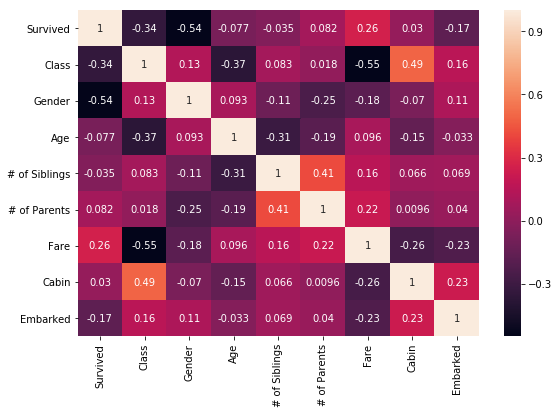

In [42]:
plot_correlation_heatmap(titanic_train.corr())

In [43]:
corr = titanic_train.corr()

<style>
table {
  font-family: arial, sans-serif;
  border-collapse: collapse;
  width: 100%;
}

td, th {
  border: 1px solid #dddddd;
  text-align: left;
  padding: 8px;
}

tr:nth-child(even) {
  background-color: #dddddd;
}
</style>

<h4>Correlation analysis table for attribute with null values:</h4>

<table>
  <tr>
    <th>Attribute</th>
    <th>Correlation with classification attribute (Survived)</th>
    <th>Max Correlation attribute 1</th>
    <th>Max Correlation attribute 2</th>  
  </tr>
  <tr>
    <td>Embarked</td>
    <td>-0.169718</td>
    <td>Fare (- 0.2263)</td>
    <td>Class (0.164681)</td>
  </tr>
  <tr>
    <td>Age</td>
    <td>-0.077221</td>
    <td>Class (-0.369226)</td>
    <td> # of Siblings (-0.308247)</td>
  </tr>
  <tr>
    <td>Cabin</td>
    <td>0.029619</td>
    <td>Class (0.493209) </td> 
    <td>Fare (-0.259622) </td>
  </tr>
</table>

### iteration 1:
**based on the above analysis the null/empty columns can be indivisually handled as follows:**
<br>

**Embarked**
- Strategy 1: remove rows where 'Embarked' attribute is null
- Strategy 2: replace with majory class
<br>

**Age**
- Strategy 1: replace with group based majority based on correlation attributes
- Strategy 2: replace with prediction model results based on correlation attributes
- Strategy 3: replace with mean or median of the column
<br>

**Cabin**
- Strategy 1: remove column from analysis dataset
- Strategy 2: replace with prediction model results based on correlation attributes

In [44]:
#step 1:
# removing rows having 'Embarked'as null
# removing attribute 'Cabin'

train_data = (titanic_train.dropna(axis = 'rows', subset=['Embarked'])
              .drop('Cabin', axis=1)
)

#step 2:
# replace 'Age' with mean value of the column based on correlation attributes
age_mean_corr = titanic_train.groupby(['Class', '# of Siblings'], as_index= False)['Age'].agg(lambda x : x.mean() if pd.isnull(x.mean()) is not True else titanic_train['Age'].mean())

def replace_null_corr(row, age_mean_corr):
    if np.isnan(row['Age']):
        row['Age'] = age_mean_corr.loc[(age_mean_corr['Class'] == row['Class']) & (age_mean_corr['# of Siblings'] == row['# of Siblings']),'Age']
    return row
train_data = train_data.apply(replace_null_corr, axis = 1, args=(age_mean_corr, ))

In [45]:
print_logistic_regression_results(train_data)

 simple logistic regg = 0.7991004497751124 
 min-max scaled logistic regg = 0.7931034482758621 
 grid -searched logistic regg = 0.8065967016491754


In [46]:
titanic_train_pca = (titanic_train.replace({np.nan : 404})
                  )

train_set, test_set, y_train, y_test = train_test_split_data(titanic_train_pca)
train_pca, test_pca = get_pca_dataset(train_set, test_set)

C:\Users\Saurabh\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Saurabh\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int32, float64 were all converted to float64 by StandardScaler.
  
C:\Users\Saurabh\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype int32, float64 were all converted to float64 by StandardScaler.
  import sys


<IPython.core.display.Javascript object>


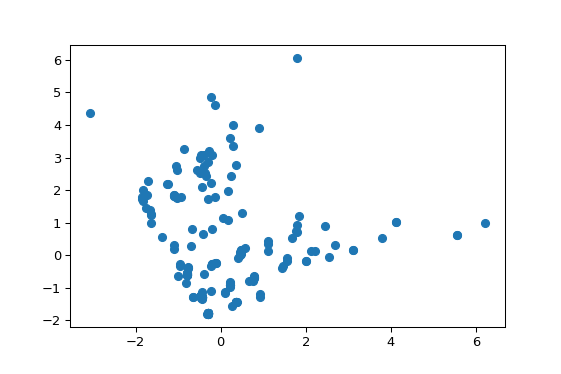

In [56]:
plot_2d_scatter(train_pca[:,0], train_pca[:,1])  # TRAIN pca representation of Titanic dataset post dimentionality reduction to 2 variables

<IPython.core.display.Javascript object>


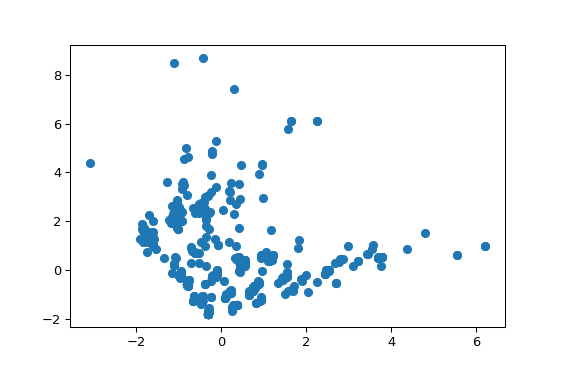

In [57]:
plot_2d_scatter(test_pca[:,0], test_pca[:,1])  # TEST pca representation of Titanic dataset post dimentionality reduction to 2 variables

[PCA Function Definition](#pca_cell)

## <font color='red'> important information below :</font>

#### Future Scope:

- automate preprocessing end to end for all features
- functional groupby for discrete values like "Fare"